# **Introduction 📱**
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### **Interconnect's services**
* Landline communication. The telephone can be connected to several lines simultaneously.
* Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.
* Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
* A dedicated technical support line (TechSupport)
* Cloud file storage and data backup (OnlineBackup)
*  TV streaming (StreamingTV) and a movie directory (StreamingMovies)



## **Initialization** 🚀

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance
import seaborn as sns

In [ ]:
contract = pd.read_csv('contract.csv')
personal = pd.read_csv('personal.csv')
internet = pd.read_csv('internet.csv')
phone = pd.read_csv('phone.csv')

In [ ]:
def qa_check(df):
    print(f"Checking {df.shape[0]} rows and {df.shape[1]} columns in DataFrame...")

    # Check data structure
    df.info()

    # Check for duplicates
    dup_count = df.duplicated().sum()
    print()
    print(f"Duplicates found: {dup_count}")
    print()

    # Count zeros
    zero_cols = {}
    for col in df.columns:
        zero_count = (df[col] == 0).sum()
        if zero_count > 0:
            zero_cols[col] = zero_count
    print("Columns with zeros:")
    for col, count in zero_cols.items():
        print(f"  {col}: {count}")
    print()

    # Count null/nan and inf/-inf
    nan_cols = {}
    for col in df.columns:
        df_inf = df[col].replace([np.inf, -np.inf], np.nan)
        nan_count = df_inf.isnull().sum()
        if nan_count > 0:
            nan_cols[col] = nan_count
    print("Columns with null/NaN values:")
    for col, count in nan_cols.items():
        print(f"  {col}: {count}")
    print()

qa_check(contract)
print()
qa_check(personal)
print()
qa_check(internet)
print()
qa_check(phone)
print()

Checking 7043 rows and 8 columns in DataFrame...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Duplicates found: 0

Columns with zeros:

Columns with null/NaN values:


Checking 7043 rows and 5 columns in DataFrame...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   

In [ ]:
print(contract.head(5))
print()
print(personal.head(5))
print()
print(internet.head(5))
print()
print(phone.head(5))
print()

   customerID   BeginDate  ... MonthlyCharges TotalCharges
0  7590-VHVEG  2020-01-01  ...          29.85        29.85
1  5575-GNVDE  2017-04-01  ...          56.95       1889.5
2  3668-QPYBK  2019-10-01  ...          53.85       108.15
3  7795-CFOCW  2016-05-01  ...          42.30      1840.75
4  9237-HQITU  2019-09-01  ...          70.70       151.65

[5 rows x 8 columns]

   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

   customerID InternetService OnlineSecurity  ... TechSupport StreamingTV StreamingMovies
0  7590-VHVEG             DSL             No  ...          No          No              No
1  5575-GNVDE             DSL            Yes  ...          No          No              No
2  3668-QPYBK   

**Comment:**

After the initialization and quality check, we see that none of the datasets include data that will be a issue to pre-process. However, based on previous experience, the datetime and objects data types may prove to be challenging. There is also the approach of encoding which needs to be applied to improve the model performance. My determination is that we are clear to proceed with the next section.

## **Feature Engineering I** ⛓

In [ ]:
# Convert BeginDate from YYYY-MM-DD to datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

# Replace 'No' with NaT in EndDate
contract['EndDate'] = contract['EndDate'].replace('No', pd.NaT)

# Convert EndDate to datetime (allowing for mixed formats)
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

# Calculate the duration and store it in a new column 'Duration'
contract['Duration'] = contract['EndDate'] - contract['BeginDate']

# Display the updated DataFrame
print("\nDataFrame with Duration:")
print(contract)


DataFrame with Duration:
      customerID  BeginDate    EndDate  ... MonthlyCharges TotalCharges Duration
0     7590-VHVEG 2020-01-01        NaT  ...          29.85        29.85      NaT
1     5575-GNVDE 2017-04-01        NaT  ...          56.95       1889.5      NaT
2     3668-QPYBK 2019-10-01 2019-12-01  ...          53.85       108.15  61 days
3     7795-CFOCW 2016-05-01        NaT  ...          42.30      1840.75      NaT
4     9237-HQITU 2019-09-01 2019-11-01  ...          70.70       151.65  61 days
...          ...        ...        ...  ...            ...          ...      ...
7038  6840-RESVB 2018-02-01        NaT  ...          84.80       1990.5      NaT
7039  2234-XADUH 2014-02-01        NaT  ...         103.20       7362.9      NaT
7040  4801-JZAZL 2019-03-01        NaT  ...          29.60       346.45      NaT
7041  8361-LTMKD 2019-07-01 2019-11-01  ...          74.40        306.6 123 days
7042  3186-AJIEK 2014-08-01        NaT  ...         105.65       6844.5      NaT

[

In [ ]:
# Merge dataframes on ['CustomerID']
# Perform right outer joins
interconnect_customer_data = (
    contract.merge(personal, on='customerID', how='right')
             .merge(internet, on='customerID', how='right')
             .merge(phone, on='customerID', how='right')
)

print(interconnect_customer_data.head(5))
print()
print(interconnect_customer_data.info())

   customerID  BeginDate    EndDate  ... StreamingTV StreamingMovies MultipleLines
0  5575-GNVDE 2017-04-01        NaT  ...          No              No            No
1  3668-QPYBK 2019-10-01 2019-12-01  ...          No              No            No
2  9237-HQITU 2019-09-01 2019-11-01  ...          No              No            No
3  9305-CDSKC 2019-03-01 2019-11-01  ...         Yes             Yes           Yes
4  1452-KIOVK 2018-04-01        NaT  ...         Yes              No           Yes

[5 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   customerID        6361 non-null   object         
 1   BeginDate         4835 non-null   datetime64[ns] 
 2   EndDate           1586 non-null   datetime64[ns] 
 3   Type              4835 non-null   object         
 4   PaperlessBilling  4835 non-null   ob

In [ ]:
# Drop the 'CustomerID' column
interconnect_customer_data = interconnect_customer_data.drop(columns=['customerID'])

In [ ]:
# Create a new boolean column 'Churn' based on EndDate
interconnect_customer_data['Churn'] = interconnect_customer_data['EndDate'].notna()

# Optionally, drop the EndDate column if no longer needed
interconnect_customer_data.drop('EndDate', axis=1, inplace=True)

# Display the updated DataFrame
print(interconnect_customer_data)

      BeginDate            Type PaperlessBilling  ... StreamingMovies  MultipleLines  Churn
0    2017-04-01        One year               No  ...              No             No  False
1    2019-10-01  Month-to-month              Yes  ...              No             No   True
2    2019-09-01  Month-to-month              Yes  ...              No             No   True
3    2019-03-01  Month-to-month              Yes  ...             Yes            Yes   True
4    2018-04-01  Month-to-month              Yes  ...              No            Yes  False
...         ...             ...              ...  ...             ...            ...    ...
6356        NaT             NaN              NaN  ...             NaN             No  False
6357 2018-02-01        One year              Yes  ...             Yes            Yes  False
6358 2014-02-01        One year              Yes  ...             Yes            Yes  False
6359 2019-07-01  Month-to-month              Yes  ...              No           

**Comment:**

My approach to feature engineering was to address the two datatype concerns, where the first was due to the YYYY-MM-DD format as an object to datetime for calculations, then use EndDate to create a new field called ['Duration']. Next, I dropped ['customerID'] because this field is a random kind of index. Lastly, I created a field called ['Churn'] based on ['EndDate'] and dropped ['EndDate'], because it didn't make sense why this date would influence whether a customer would churn.

## **Exploratory Data Analysis** 🔍

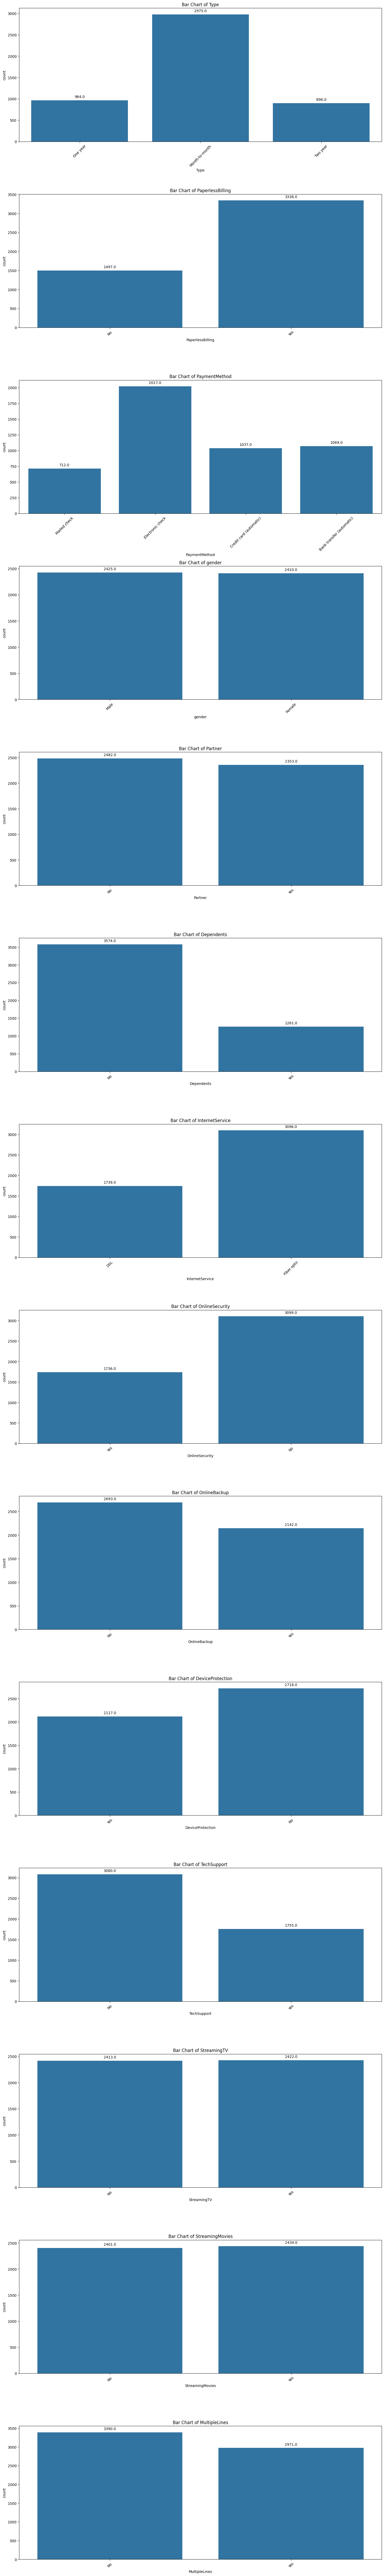

In [ ]:
# Bar charts for categorical columns
categorical_columns = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'gender',
    'Partner',
    'Dependents',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines'
]

# Set figure size to increase height
plt.figure(figsize=(15, 100))  # Adjusted height

for i, col in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns), 1, i + 1)
    ax = sns.countplot(data=interconnect_customer_data, x=col)
    plt.title(f'Bar Chart of {col}')
    plt.xticks(rotation=45)

    # Adding data labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black',
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords='offset points')

plt.tight_layout()
plt.show()

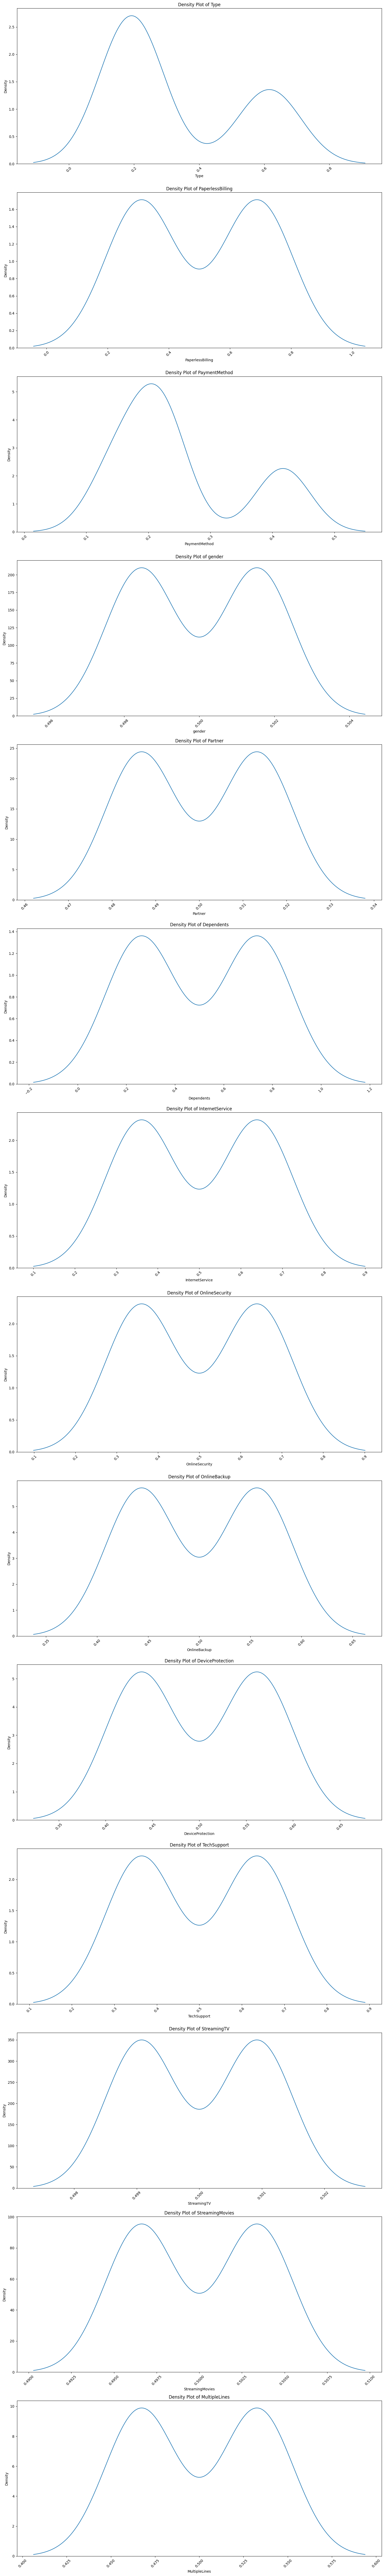

In [ ]:
# Set figure size to increase height
plt.figure(figsize=(15, 100))  # Adjusted height

for i, col in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns), 1, i + 1)

    # Calculate counts and create a density-like plot
    counts = interconnect_customer_data[col].value_counts(normalize=True)
    sns.kdeplot(counts, bw_adjust=0.5)  # Using kdeplot to visualize density
    plt.title(f'Density Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Comment:**


Results from the data exploration show that the classes are relatively balanced compared to other datasets that I've worked with, so I do not anticipate the use over up- or downsampling. The visualizations demonstrate the two states of the variables, so things are checking out smoothly so far. I decided to add kernel density estimates, because I think that the visualization is more streamlined than the histoplots, however in this case, I don't see that much added value in terms of communications/insights.

## **Feature Engineering II** 🏷

In [ ]:
# Apply One-Hot Encoding to the specified columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype          
---  ------                                 --------------  -----          
 0   BeginDate                              4835 non-null   datetime64[ns] 
 1   MonthlyCharges                         4835 non-null   float64        
 2   TotalCharges                           4835 non-null   object         
 3   Duration                               1586 non-null   timedelta64[ns]
 4   SeniorCitizen                          4835 non-null   float64        
 5   Churn                                  6361 non-null   bool           
 6   Type_One year                          6361 non-null   bool           
 7   Type_Two year                          6361 non-null   bool           
 8   PaperlessBilling_Yes                   6361 non-null   bool           
 9   PaymentMethod_Credit card (automatic)  6361 non-null

In [ ]:
# Check the data types of the features

BeginDate                                 datetime64[ns]
MonthlyCharges                                   float64
TotalCharges                                      object
Duration                                 timedelta64[ns]
SeniorCitizen                                    float64
Churn                                               bool
Type_One year                                       bool
Type_Two year                                       bool
PaperlessBilling_Yes                                bool
PaymentMethod_Credit card (automatic)               bool
PaymentMethod_Electronic check                      bool
PaymentMethod_Mailed check                          bool
gender_Male                                         bool
Partner_Yes                                         bool
Dependents_Yes                                      bool
InternetService_Fiber optic                         bool
OnlineSecurity_Yes                                  bool
OnlineBackup_Yes               

In [ ]:
# Set up and run KNN imputer to fill in gaps

         BeginDate  MonthlyCharges  ...  StreamingMovies_Yes  MultipleLines_Yes
0     1.491005e+09       56.950000  ...                  0.0                0.0
1     1.569888e+09       53.850000  ...                  0.0                0.0
2     1.567296e+09       70.700000  ...                  0.0                0.0
3     1.551398e+09       99.650000  ...                  1.0                1.0
4     1.522541e+09       89.100000  ...                  0.0                1.0
...            ...             ...  ...                  ...                ...
6356 -9.223372e+09       94.416667  ...                  0.0                0.0
6357  1.517443e+09       84.800000  ...                  1.0                1.0
6358  1.391213e+09      103.200000  ...                  1.0                1.0
6359  1.561939e+09       74.400000  ...                  0.0                1.0
6360  1.406851e+09      105.650000  ...                  1.0                0.0

[6361 rows x 23 columns]


**Comment:**

## **Model Evaluation** 🥇

* **Logistic Regression** - Logistic regression builds upon linear regression, which models a continuous relationship between variables. To map the linear regression output to a probability between 0 and 1, we apply the sigmoid function. The output of the sigmoid function represents the probability of the positive class (e.g., email being spam). A threshold is set (often 0.5) to classify instances.
      # https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

* **Random Forest Regressor** – a regression algorithm that uses an ensemble of decision trees to predict continuous numerical values. It is similar to the Random Forest Classifier, but instead of predicting class labels, it predicts a real number.
      # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

* **XGBoost Regressor** – a supervised learning algorithm that uses gradient boosting to train a model for regression problems. It is a popular choice for regression tasks due to its high accuracy and efficiency.
      # https://xgboost.readthedocs.io/en/stable/python/index.html


In [ ]:
# Define features and target


# Split the dataset into training and testing sets

In [ ]:
# Set up the logistic regression model

# Print results

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters:
{'solver': 'liblinear', 'random_state': 42, 'penalty': 'l1', 'max_iter': 300, 'class_weight': None, 'C': 1}
ROC-AUC: 0.8709
F1 Score: 0.6107


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
145 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/

In [ ]:
# Set up the random forest model


# Print results


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy', 'ccp_alpha': 0.0, 'bootstrap': True}
ROC-AUC: 0.9745
F1 Score: 0.8529


In [ ]:
# Set up the XGBoost regression model


# Print results

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters:
{'subsample': 0.8, 'scale_pos_weight': 3, 'reg_lambda': 1, 'reg_alpha': 0.1, 'random_state': 42, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}
ROC-AUC: 0.9839
F1 Score: 0.8822


In [ ]:
# Plot results

**Comment:**



## **Feature Importance** ⏮

In [ ]:
# investigate the linear correlations between features

In [ ]:
# investigate feature importance and contrast between the three models used (LogisticRegression(), RandomForestClassifier), and XGBClassifier())

In [ ]:
# investigate the impact of permutation testing on feature importance for the best model

**Comment:**

## **Conclusion** ✔